In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

from statsmodels.distributions.empirical_distribution import ECDF

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.89 s
Wall time: 21.1 s


In [3]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

ref_literature = datasets.reference_publications(taxon)

agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

gene2pubmed = gene2lit
gene2pubmed = pd.merge(gene2pubmed, ml, how='left')
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values

# no cutoff year
gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:

# Main figure

In [4]:
df_array = []

t = pd.read_csv('../data/gwas_all_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_all_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_all_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_all_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [6]:
ml[ml['pubmed_id'].isin(hits_df['pubmed_id'])]['year'].min()

2004

In [7]:
pmid_dict = hits_df.groupby('type')['pubmed_id'].apply(set)

In [8]:
prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

In [9]:
def pval_str(pval):
    pval_str = ''
    if pval < 0.05:
        pval_str += '*'
    if pval < 0.01:
        pval_str += '*'
    if pval < 0.001:
        pval_str += '*'
    if pval >= 0.05:
        pval_str = 'n.s.'
    return pval_str

Main figure

Log scale

0.0033147585487924252
6.317701500497152e-06
1.4195598313245077e-61
4.798210221053984e-229
1.8191748189947602e-37
2.6048900981444733e-48
1.1777794574064508e-11
3.240878165209273e-17


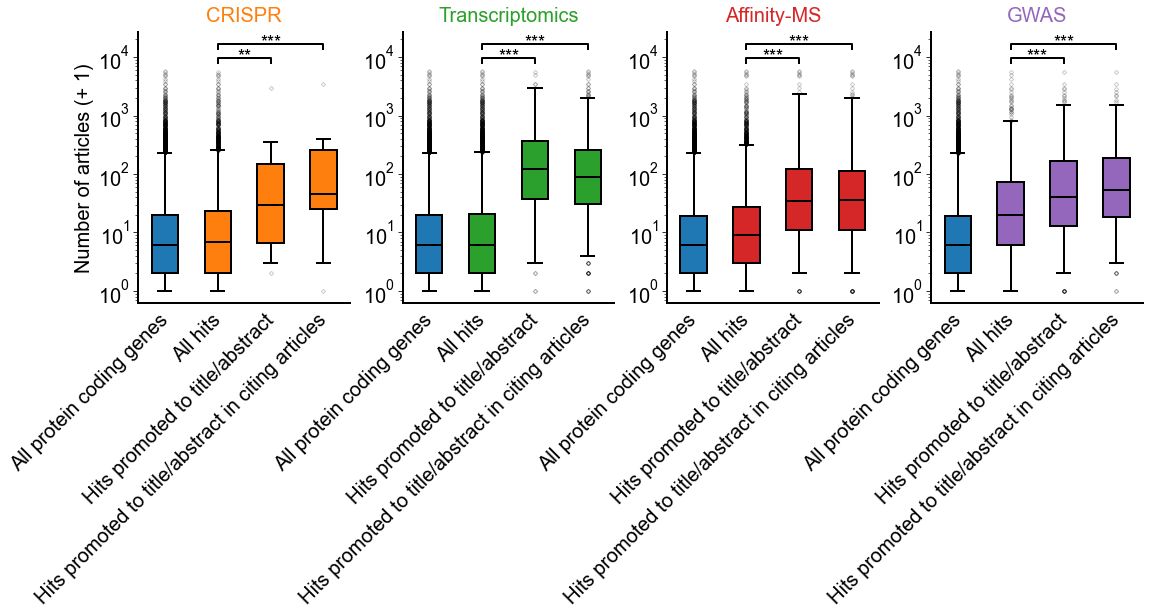

In [9]:
def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0))[0].values]
            # no +1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 8_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 14_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.25})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1])
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2])
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('Affinity-MS', fontsize=20, pad=10, color=sns.color_palette()[3])
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4])
axes[0].set_ylabel('Number of articles (+ 1)', fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    #ax.set_ylim([-1,1000])
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=['All protein coding genes', 
                          'All hits', 
                          'Hits promoted to title/abstract', 
                          'Hits promoted to title/abstract in citing articles'])
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    
#plt.savefig('../img/horizontal_filter_figure.png', dpi=300, bbox_inches='tight')
#plt.savefig('../img/horizontal_filter_figure.pdf', bbox_inches='tight')

#export.image('general', p='figures/horizontal_filter_figure.pdf', date=True)
#export.raster_image('general', p='figures/horizontal_filter_figure.png', date=True, dpi=600)

Linear scale

0.0033147585487924252
6.317701500497152e-06
1.4195598313245077e-61
4.798210221053984e-229
1.8191748189947602e-37
2.6048900981444733e-48
1.1777794574064508e-11
3.240878165209273e-17


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


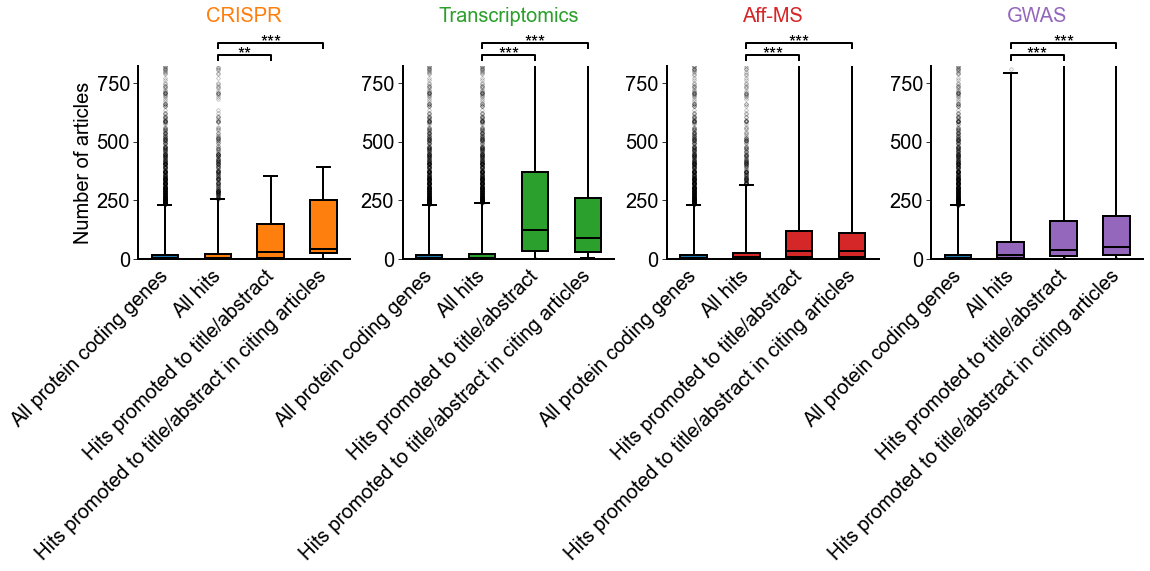

In [39]:
def plot_boxplot(ax, ax_upper, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0)-1)[0].values]
            # -1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 500
    yh = y+20
    ax_upper.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax_upper.text(s=pval_str(p), x=1.5, y=yh, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 550
    yh = y+20
    ax_upper.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax_upper.text(s=pval_str(p), x=2, y=yh, ha='center', va='center', fontsize=18)
    ax_upper.set_xlim(ax.get_xlim())
    ax_upper.axis(False)
    
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,4), 
                         gridspec_kw={'wspace':0.25, 'hspace':0.05, 
                                      'height_ratios':[0.1,1]})

plot_boxplot(axes[1][0], axes[0][0], 'crispr', color=sns.color_palette()[1])
axes[0][0].set_title('CRISPR', fontsize=20, pad=20, color=sns.color_palette()[1])
plot_boxplot(axes[1][1], axes[0][1], 'transcriptomics', color=sns.color_palette()[2])
axes[0][1].set_title('Transcriptomics', fontsize=20, pad=20, color=sns.color_palette()[2])
plot_boxplot(axes[1][2], axes[0][2],'aff_ms', color=sns.color_palette()[3])
axes[0][2].set_title('Affinity-MS', fontsize=20, pad=20, color=sns.color_palette()[3])
plot_boxplot(axes[1][3], axes[0][3], 'gwas', color=sns.color_palette()[4])
axes[0][3].set_title('GWAS', fontsize=20, pad=20, color=sns.color_palette()[4])
axes[1][0].set_ylabel('Number of articles', fontsize=20)

for ax in axes[1]:
    #ax.set_yscale('log')
    ax.set_ylim([-1,820])
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=['All protein coding genes', 
                          'All hits', 
                          'Hits promoted to title/abstract', 
                          'Hits promoted to title/abstract in citing articles'])
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    
plt.savefig('../img/horizontal_filter_figure_linear.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure_linear.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure_linear.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure_linear.png', date=True, dpi=600)

Without +1 counts

In [15]:
np.percentile((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values, 80)

25.0

0.0033147585487924252
6.317701500497152e-06
1.4195598313245077e-61
4.798210221053984e-229
1.8191748189947602e-37
2.6048900981444733e-48
1.1777794574064508e-11
3.240878165209273e-17


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


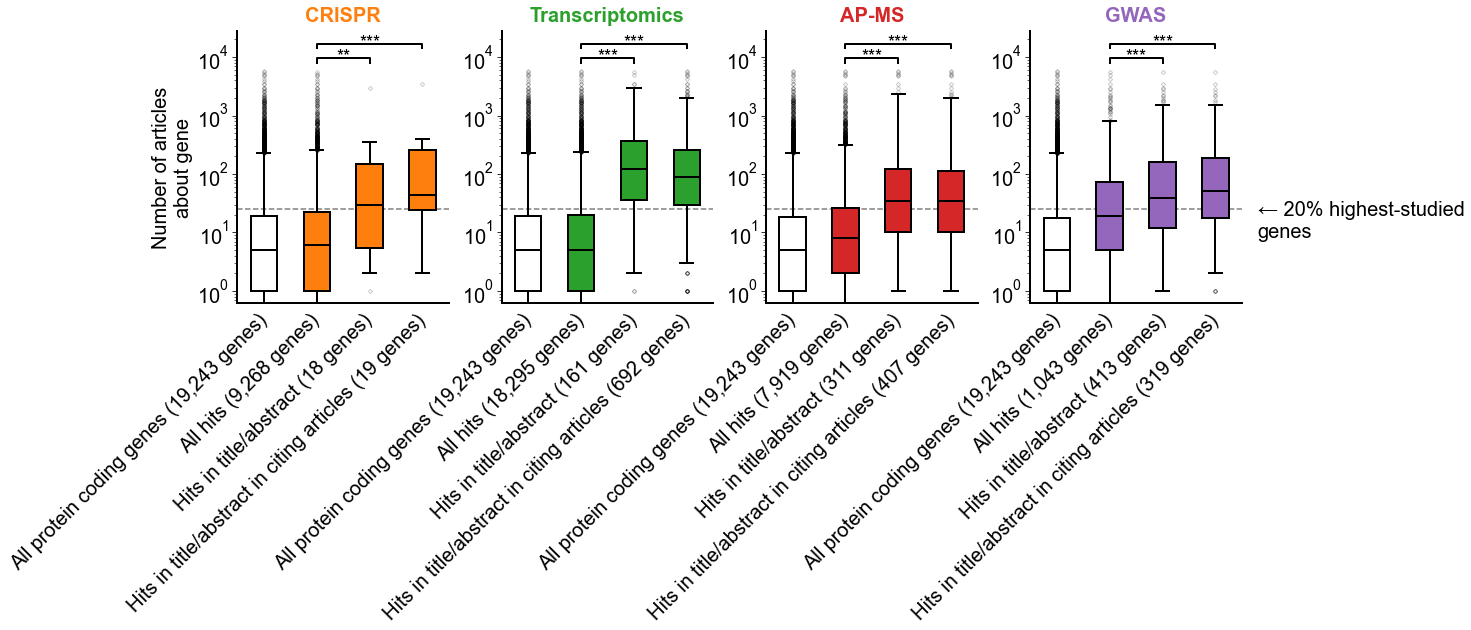

In [11]:
def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0)-1)[0].values]
            # -1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor='w', linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.axhline(np.percentile(data[0], 80), linestyle='dashed', color='k', zorder=-1, alpha=0.5)
    
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 8_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 14_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # x tick labels
    x_tick_labels = ['All protein coding genes', 
                          'All hits', 
                          'Hits in title/abstract', 
                          'Hits in title/abstract in citing articles']
    
    for ii in range(4):
        x_tick_labels[ii] = x_tick_labels[ii] + ' (' + '{:,}'.format(len(data[ii])) + ' genes)'
        
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=x_tick_labels)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.25})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1], weight='bold')
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2], weight='bold')
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('AP-MS', fontsize=20, pad=10, color=sns.color_palette()[3], weight='bold')
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4], weight='bold')
axes[0].set_ylabel('Number of articles\nabout gene', fontsize=20)
#axes[3].arrow(x=4, y=25, dx=-0.2, dy=0, width=1, color='k', length_includes_head=True)
axes[3].text(x=3.8,y=35, s='← 20% highest-studied\ngenes', ha='left', va='top',
             color='k', alpha=1, fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    #ax.set_ylim([-1,1000])
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    
plt.savefig('../img/horizontal_filter_figure.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure.png', date=True, dpi=600)

As % of all studies involving genes?

0.0033147585487924252
3.5752723020063057e-06
1.4195598313245077e-61
5.70260619043781e-234
1.8191748189947602e-37
4.517997653431082e-52
1.1777794574064508e-11
3.870993049558446e-18


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


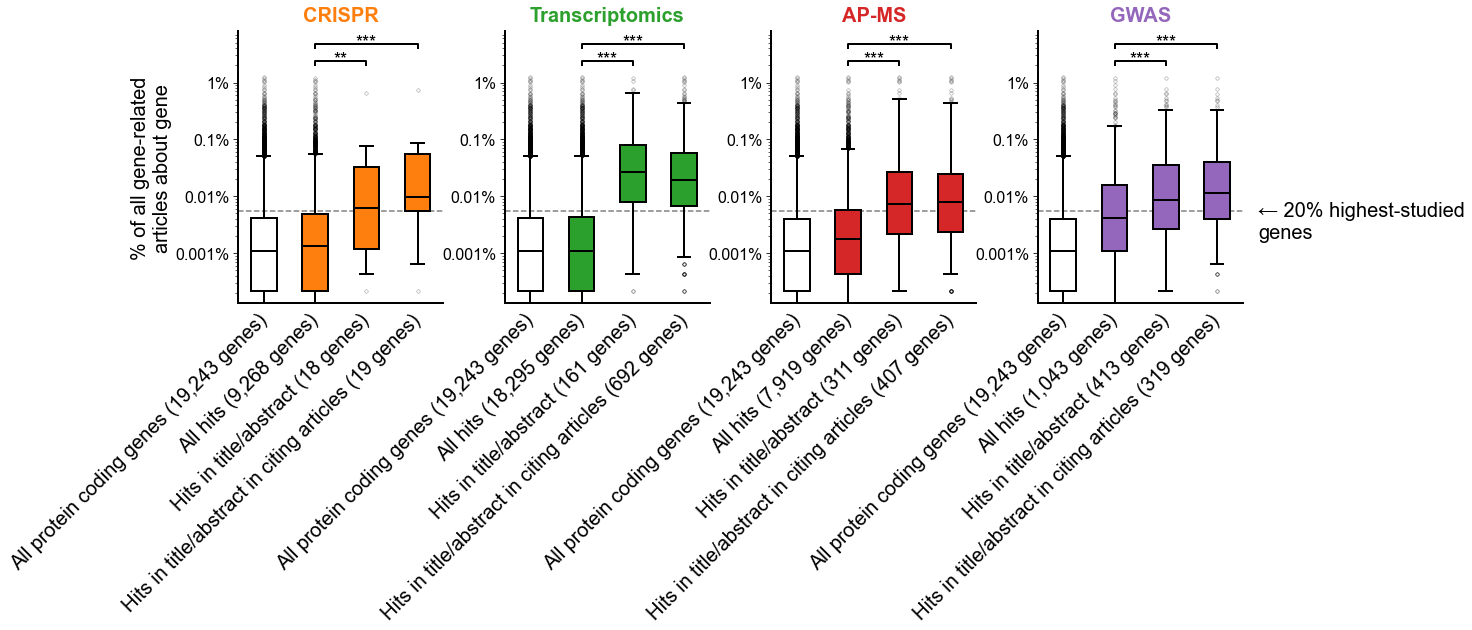

In [12]:
def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    total_studies = gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get('gwas'))]['pubmed_id'].nunique()
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(100*pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values/total_studies,
        (100*pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values/total_studies,
           (100*pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values/total_studies, 
           (100*pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0)-1)[0].values/total_studies]
            # -1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor='w', linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.axhline(np.percentile(data[0], 80), linestyle='dashed', color='k', zorder=-1, alpha=0.5)
    
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 2
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2,c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 4
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)
    
        # x tick labels
    x_tick_labels = ['All protein coding genes', 
                          'All hits', 
                          'Hits in title/abstract', 
                          'Hits in title/abstract in citing articles']
    
    for ii in range(4):
        x_tick_labels[ii] = x_tick_labels[ii] + ' (' + '{:,}'.format(len(data[ii])) + ' genes)'
        
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=x_tick_labels)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.3})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1], weight='bold')
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2], weight='bold')
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('AP-MS', fontsize=20, pad=10, color=sns.color_palette()[3], weight='bold')
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4], weight='bold')
axes[0].set_ylabel('% of all gene-related\narticles about gene', fontsize=20)
#axes[3].arrow(x=4, y=25, dx=-0.2, dy=0, width=1, color='k', length_includes_head=True)
axes[3].text(x=3.8,y=0.008, s='← 20% highest-studied\ngenes', ha='left', va='top',
             color='k', alpha=1, fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    #a.set_ylim([-0.01,1.5])
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    ax.set_yticks(ticks=[1e-3, 1e-2, 1e-1, 1e0], labels=['0.001%', '0.01%', '0.1%', '1%'], fontsize=16)
    
plt.savefig('../img/horizontal_filter_figure_percent.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure_percent.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure_percent.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure_percent.png', date=True, dpi=600)

# Only one gene per title/abstract

0.014885377795797385
0.024389136062491313
7.114957218844569e-51
3.437385357937667e-51
6.909854818816341e-35
1.244048622931811e-25
3.3410796172811423e-13
1.0827367960480288e-15


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


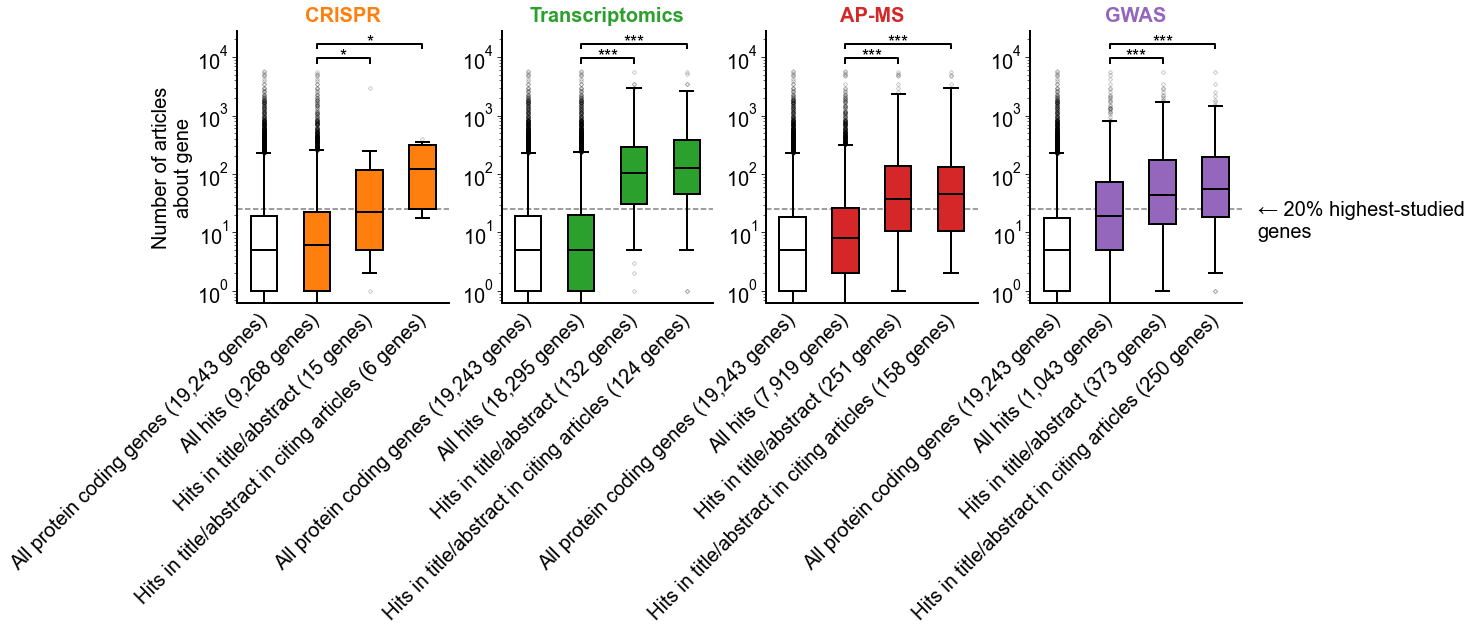

In [13]:
np.random.seed(50)

def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = \
    set(hits_df_slice[hits_df_slice['mentioned']].sample(frac=1)\
        .drop_duplicates(subset=['pubmed_id'], keep='first')['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = \
    set(hits_df_slice[hits_df_slice['mentioned_citations']].sample(frac=1)\
        .drop_duplicates(subset=['pubmed_id'], keep='first')['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0)-1)[0].values]
            # -1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor='w', linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    
    
    ax.axhline(np.percentile(data[0], 80), linestyle='dashed', color='k', zorder=-1, alpha=0.5)
    
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 8_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 14_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)
    
            # x tick labels
    x_tick_labels = ['All protein coding genes', 
                          'All hits', 
                          'Hits in title/abstract', 
                          'Hits in title/abstract in citing articles']
    
    for ii in range(4):
        x_tick_labels[ii] = x_tick_labels[ii] + ' (' + '{:,}'.format(len(data[ii])) + ' genes)'
        
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=x_tick_labels)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.25})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1], weight='bold')
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2], weight='bold')
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('AP-MS', fontsize=20, pad=10, color=sns.color_palette()[3], weight='bold')
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4], weight='bold')
axes[0].set_ylabel('Number of articles\nabout gene', fontsize=20)
#axes[3].arrow(x=4, y=25, dx=-0.2, dy=0, width=1, color='k', length_includes_head=True)
axes[3].text(x=3.8,y=35, s='← 20% highest-studied\ngenes', ha='left', va='top',
             color='k', alpha=1, fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    #ax.set_ylim([-1,1000])
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    
plt.savefig('../img/horizontal_filter_figure_one_per_abstract.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure_one_per_abstract.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure_one_per_abstract.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure_one_per_abstract.png', date=True, dpi=600)

# Before 2003

0.08555388411564865
0.0007841227792547982
3.2077168962383254e-45
3.8587191903372124e-144
3.724406021403275e-14
4.111630725901587e-20
2.585714114707643e-06
4.0753821523652326e-08


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


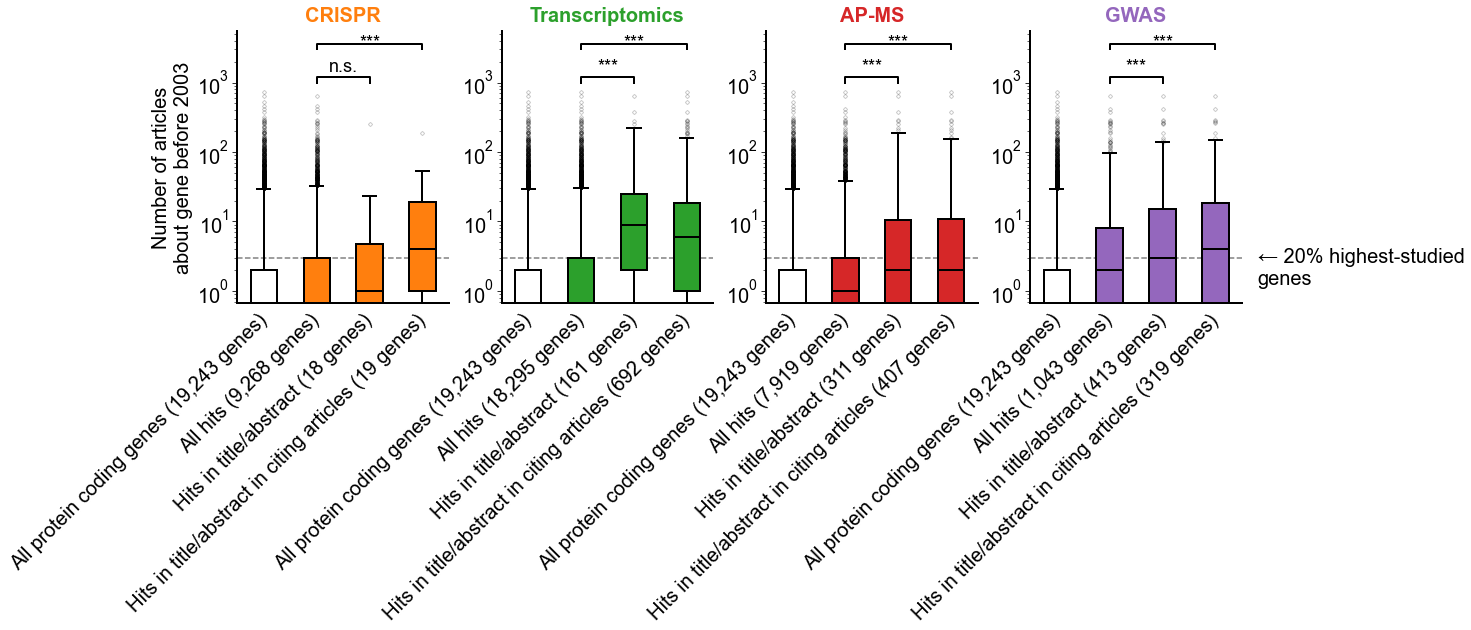

In [14]:
def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[gene2pubmed['year'] <= 2002]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0))[0].values]


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor='w', linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.axhline(np.percentile(data[0], 80), linestyle='dashed', color='k', zorder=-1, alpha=0.5)
        
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 1_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='bottom', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 3_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)
    
            # x tick labels
    x_tick_labels = ['All protein coding genes', 
                          'All hits', 
                          'Hits in title/abstract', 
                          'Hits in title/abstract in citing articles']
    
    for ii in range(4):
        x_tick_labels[ii] = x_tick_labels[ii] + ' (' + '{:,}'.format(len(data[ii])) + ' genes)'
        
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=x_tick_labels)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.25})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1], weight='bold')
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2], weight='bold')
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('AP-MS', fontsize=20, pad=10, color=sns.color_palette()[3], weight='bold')
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4], weight='bold')
axes[0].set_ylabel('Number of articles\nabout gene before 2003', fontsize=20)
axes[3].text(x=3.8,y=4.3, s='← 20% highest-studied\ngenes', ha='left', va='top',
             color='k', alpha=1, fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(axes[0].get_ylim())
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
    
plt.savefig('../img/horizontal_filter_figure_up_to_2003.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure_up_to_2003.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure_up_to_2003.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure_up_to_2003.png', date=True, dpi=600)

Alternate p value thresholds

In [15]:
df_array = []

t = pd.read_csv('../data/gwas_all_hits_1e-10.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_all_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_all_hits_0.0001.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_all_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

0.0033147585487924252
6.317701500497152e-06
1.5505411251975383e-34
3.201690670194472e-119
1.8191748189947602e-37
2.6048900981444733e-48
1.6162770162512436e-09
1.32425216499079e-09


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


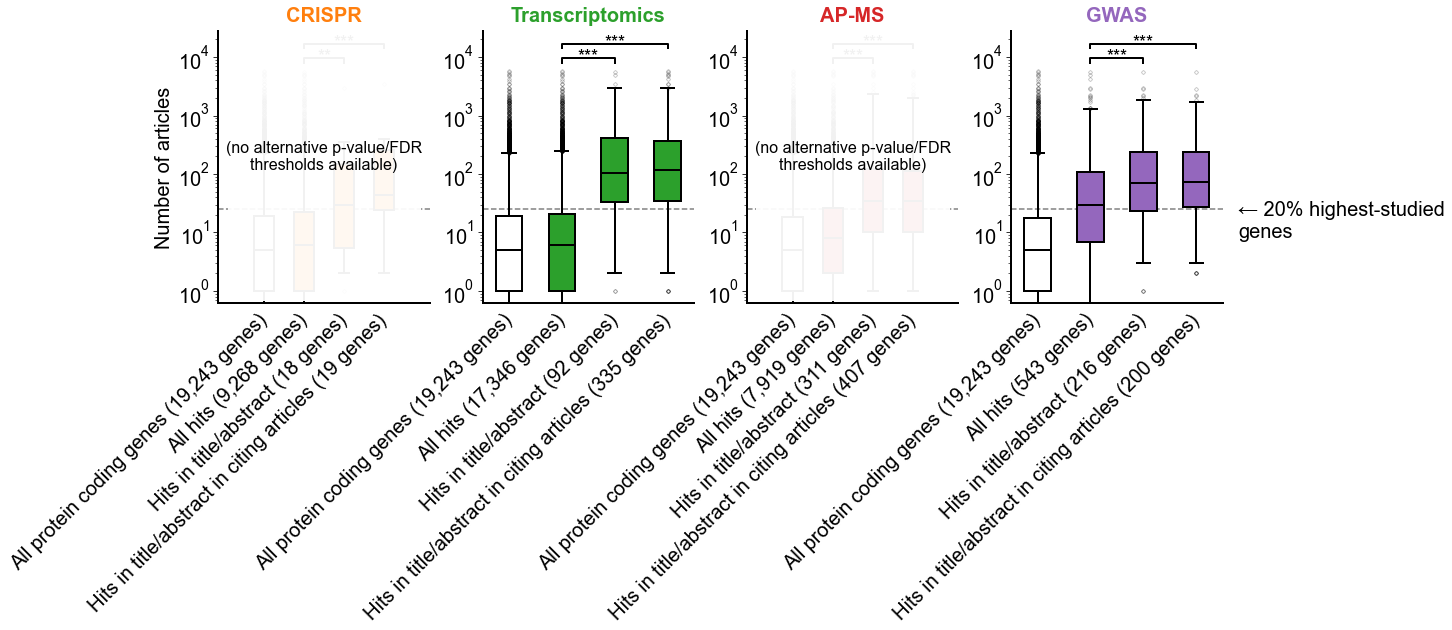

In [16]:
def plot_boxplot(ax, hit_type='transcriptomics', 
                 color=sns.color_palette()[0]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    pad = 0.2

    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')
    flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0)-1)[0].values]
            # -1 on citations_mentioned_hits since gene2pubmed_dict will necessarily 
            #include one title/abstract from the citing article


    positions = [0,1,2,3]
    
    ax.boxplot(x=data[0],
              vert=True, 
               positions=[positions[0]],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor='w', linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.boxplot(x=data[1:],
              vert=True, 
               positions=positions[1:],
               widths=0.5,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    ax.axhline(np.percentile(data[0], 80), linestyle='dashed', color='k', zorder=-1, alpha=0.5)
    
    # test abstract against all hits
    x1, x2 = 1, 2
    y = 8_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[2])
    print(p)
    ax.text(s=pval_str(p), x=1.5, y=yh*1.05, ha='center', va='center', fontsize=18)
    
    # test citing against all hits
    x1, x2 = 1, 3
    y = 14_000
    yh = y*1.2
    ax.plot([x1, x1, x2, x2], [y, yh, yh, y], lw=2, c='k')
    stat, p = scipy.stats.mannwhitneyu(data[1], data[3])
    print(p)
    ax.text(s=pval_str(p), x=2, y=yh*1.05, ha='center', va='center', fontsize=18)
    
                # x tick labels
    x_tick_labels = ['All protein coding genes', 
                          'All hits', 
                          'Hits in title/abstract', 
                          'Hits in title/abstract in citing articles']
    
    for ii in range(4):
        x_tick_labels[ii] = x_tick_labels[ii] + ' (' + '{:,}'.format(len(data[ii])) + ' genes)'
        
    ax.set_xticks(ticks = [0,1,2,3], 
                  labels=x_tick_labels)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,5), gridspec_kw={'wspace':0.25})

plot_boxplot(axes[0], 'crispr', color=sns.color_palette()[1])
axes[0].set_title('CRISPR', fontsize=20, pad=10, color=sns.color_palette()[1], weight='bold')
plot_boxplot(axes[1], 'transcriptomics', color=sns.color_palette()[2])
axes[1].set_title('Transcriptomics', fontsize=20, pad=10, color=sns.color_palette()[2], weight='bold')
plot_boxplot(axes[2], 'aff_ms', color=sns.color_palette()[3])
axes[2].set_title('AP-MS', fontsize=20, pad=10, color=sns.color_palette()[3], weight='bold')
plot_boxplot(axes[3], 'gwas', color=sns.color_palette()[4])
axes[3].set_title('GWAS', fontsize=20, pad=10, color=sns.color_palette()[4], weight='bold')
axes[0].set_ylabel('Number of articles', fontsize=20)

axes[3].text(x=3.8,y=35, s='← 20% highest-studied\ngenes', ha='left', va='top',
             color='k', alpha=1, fontsize=20)

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(axes[0].get_ylim())
    ax.tick_params(axis='both', labelsize=20, bottom=False)
    ax.tick_params(axis='y', length=5, which='major')
    ax.tick_params(axis='y', length=3, which='minor')
    ax.tick_params(axis='x', pad=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')

axes[0].fill_between(y1=[0.7,0.7], 
                     y2=[axes[0].get_ylim()[1],axes[0].get_ylim()[1]], 
                     x=[-0.9,3.9], color='w', zorder=100, alpha=0.95)
axes[0].text(s='(no alternative p-value/FDR\nthresholds available)', 
                        x=1.5, 
                        y=200, ha='center', va='center', fontsize=16, zorder=200)

axes[2].fill_between(y1=[0.7,0.7], 
                     y2=[axes[0].get_ylim()[1],axes[0].get_ylim()[1]], 
                     x=[-0.9,3.9], color='w', zorder=100, alpha=0.95)
axes[2].text(s='(no alternative p-value/FDR\nthresholds available)', 
                        x=1.5, 
                        y=200, ha='center', va='center', fontsize=16, zorder=200)

plt.savefig('../img/horizontal_filter_figure_alt_p.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/horizontal_filter_figure_alt_p.pdf', bbox_inches='tight')

export.image('general', p='figures/horizontal_filter_figure_alt_p.pdf', date=True)
export.raster_image('general', p='figures/horizontal_filter_figure_alt_p.png', date=True, dpi=600)